## Notebook for inferrering inference in a TAP brain

In [1]:
%pylab inline
import sys
sys.path.append('../code')
from notebookutils import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Set noise seed
noise_seed = 2022
np.random.seed(noise_seed)
torch.manual_seed(noise_seed)
print('noise_seed = %d' %(noise_seed))

noise_seed = 2022


## 1. Load the model brain

In [4]:
print(torch.__version__)

2.2.2


In [5]:
brain_name = 'Ns_10_Nr_500_noiseseed_2022'

use_cuda = False
tapbrain, theta, params = loadbrain('../data/brains/' + brain_name, use_cuda)

Ns = params['Ns']
Ny = params['Ny']
Nr = params['Nr']
print("Number of states",Ns)
print("Number of observations",Ny)
print("Number of neurons",Nr)

lam, G, J, U, V = extractParams(theta, 18, Ns, Ny, Nr) # get model brain parameters

# set process and observation noise
q_process, q_obs = 1e-5, 1.2e-1
Q_process, Q_obs = q_process*np.eye(Ns), q_obs*np.eye(Nr)  
params['Q_process'] = Q_process
params['Q_obs'] = Q_obs

# model_type -- 1: Ux + b, 0: Ux
model_type = 1 if np.any(U<0) else 0
baseline = params['baseline'] if model_type else 0

Number of states 10
Number of observations 10
Number of neurons 500


## 2. Initialize the parameters to be estimated: G, J, U, and V

### 2.1 Use ICA to get initial estimate of embedding matrix

In [6]:
# Generate measurements using high gain inputs.

B, T = 2000, 50 
T_low, T_high = 2, 5
yG_low, yG_high = 50, 50
T_clip = 20

# r_ICA = generate_TAPbrain_dynamics(tapbrain,theta, params, B, T, T_low, T_high, yG_low, yG_high, T_clip, use_cuda)[2]
y_ICA, x_ICA, r_ICA = generate_TAPbrain_dynamics(tapbrain,theta, params, B, T, T_low, 
                                                 T_high, yG_low, yG_high, T_clip, use_cuda)


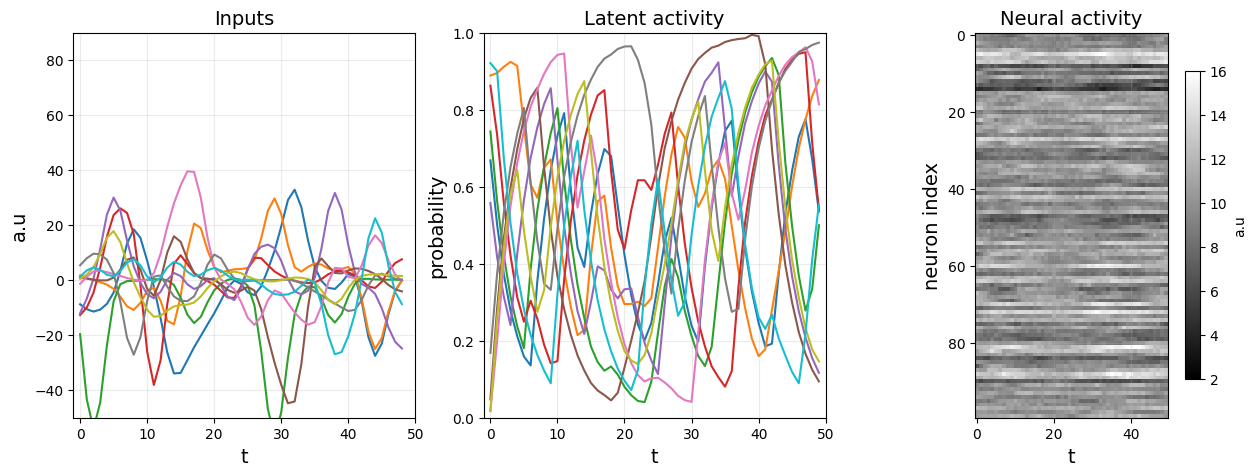

In [7]:
# if you get an error that np is not defined run first cell in TrainTAPbrain.ipynb to load necessary dependencies
fig, axs = plt.subplots(1,3, figsize=(15, 5))

axs[0].plot(y_ICA[0].T)
axs[1].plot(x_ICA[0].T)
pcm = axs[2].imshow(r_ICA[0, 0:100], cmap='gray', vmin=2, vmax=16)
fig.colorbar(pcm, ax=axs[2], shrink=0.8, label='a.u')

axs[0].axis([-1, 50, -50, 90])
axs[1].axis([-1, 50, 0, 1])
# axs[2].axis([-1, 50, 2, 16])

for ax in axs:
    ax.grid(True, alpha=0.25)
    ax.set_xlabel('t', fontsize=14)

axs[0].set_ylabel('a.u', fontsize=14)
axs[1].set_ylabel('probability', fontsize=14)
axs[2].set_ylabel('neuron index', fontsize=14)
    
axs[0].set_title('Inputs', fontsize=14)
axs[1].set_title('Latent activity', fontsize=14)
axs[2].set_title('Neural activity', fontsize=14)
axs[2].set_aspect('equal')
    

plt.show()

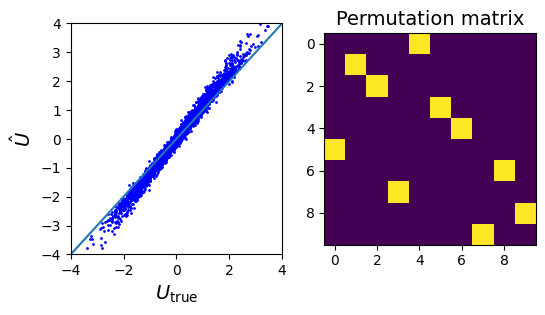

In [10]:
# Run ICA 
# We use ICA to get the embedding matrix from the RNN, which maps neural activity to latent probabilities 
# where we maximize the independence of each latent node. Then we compare this to the actual embedding matrix 
# we trained the model to use.
b_init = np.mean(r_ICA) if model_type else 0
U_init = UhatICA(np.reshape(r_ICA.transpose(1,2,0)-b_init,[Nr,T*B],order='F').T, Ns)[0]

PermMat_init = EstimatePermutation_ICA(U,U_init) # Estimate the permutation matrix P

# Plot estimate of embedding and permutation matrix
umax = np.ceil(np.max(U))
umin = np.floor(np.min(U))

fig, ax = plt.subplots(1,2,figsize=(6,3))
ax[0].plot(U.flatten(),np.dot(U_init,PermMat_init).flatten(),'b.',markersize=2)
# ax[0].plot([umin,umax],[umin,umax],Linewidth=0.5)
ax[0].plot([umin,umax],[umin,umax])

ax[0].axis([umin,umax,umin,umax])
ax[0].set_xlabel(xlabel=r'$U_{\mathrm{true}}$', fontsize=14)
ax[0].set_ylabel(ylabel=r'$\hat{U}$', fontsize=14)
ax[1].imshow(PermMat_init)
ax[1].set_title('Permutation matrix', fontsize=14)
plt.show()

### 2.2. Initialize the rest of the parameters

In [11]:
G_init    = 0.01*np.random.randn(18)
G_init[0], G_init[8], G_init[9], G_init[17] = 0, 0, 0, 0

J_init    = 0.1*Create_J(Ns, 0, params['Jtype'], params['self_coupling_on'])  # create a fully connected initial J with small initial values

if Ns <= Ny:
    V_init = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[2]
else:
    V_init = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[0]

### 3. Generate measurements for the particle EM algorithm

In [13]:
#B, T = 25000, 15
B, T = 2500, 15
yG_low, yG_high = 5, 25
B_test = 100

y, x, r_brain = generate_TAPbrain_dynamics(tapbrain,theta, params, B+B_test, T, T_low, T_high, yG_low, yG_high, T_clip, use_cuda)

mean SNR = 5.5


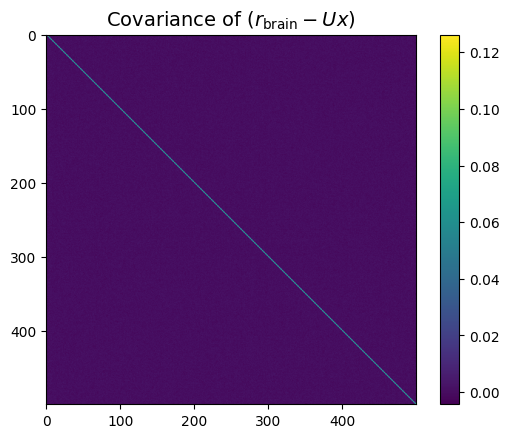

In [14]:
# Compute SNR

SNR, C_sig, C_err = computeSNR(r_brain-baseline, x, U)
print('mean SNR = %.1f' %(SNR))

plt.imshow(C_err)
plt.title(r'Covariance of $(r_{\mathrm{brain}} - Ux)$',fontsize=14)
plt.colorbar()
plt.show()

In [15]:
# Inspect and update update Q_obs.

# print(f"variance of measurement noise = {np.mean(np.diag(C_err)):.2f}")
Q_obs = np.diag(np.diag(C_err))

In [16]:
# Convert data to torch tensors

device, dtype = "cpu", torch.float64

Q_process_ = torch.tensor(Q_process,device=device,dtype=dtype)
Q_obs_     = torch.tensor(Q_obs,device=device,dtype=dtype)

P_process_ = Q_process_.inverse()
P_obs_     = Q_obs_.inverse()

r_brain_   = torch.tensor(r_brain,device=device,dtype=dtype)
y_         = torch.tensor(y,device=device,dtype=dtype)


G_      = torch.tensor(G,device=device,dtype=dtype,requires_grad=False)
J_      = torch.tensor(J,device=device,dtype=dtype,requires_grad=False)
U_      = torch.tensor(U,device=device,dtype=dtype,requires_grad=False)
V_      = torch.tensor(V,device=device,dtype=dtype,requires_grad=False)

G_hat_  = torch.tensor(G_init,device=device,dtype=dtype,requires_grad=True)
U_hat_  = torch.tensor(U_init,device=device,dtype=dtype,requires_grad=True)
V_hat_  = torch.tensor(V_init,device=device,dtype=dtype,requires_grad=True)
J_hat_vec_ = torch.tensor(JMatToVec(J_init),device=device,dtype=dtype,requires_grad=True)
J_hat_ = JVecToMat_torch(J_hat_vec_,Ns)
b_hat_ = torch.tensor(b_init,device=device,dtype=dtype,requires_grad=True) if model_type else 0

### 3.1 Compare PF estimates with true parameters vs. initial values

In [18]:
# Run PF with true values of parameters
 
Np = 100 # No. of particles to use (essentially the number of batches)

with torch.no_grad():
    LL_tp_, x_tp_, _, _ = particlefilter(G_, J_, U_, V_, lam.item(), r_brain_[B:]-baseline, y_[B:], P_process_, P_obs_, Np)

r_tp_ = torch.matmul(U_,x_tp_) + baseline
    

# Run PF with initial values of parameters

t_st = time.time()
with torch.no_grad():
    LL_hat_, x_hat_, _, _ = particlefilter(G_hat_, J_hat_, U_hat_, V_hat_, lam.item(), r_brain_[B:]-b_init, y_[B:], P_process_, P_obs_, Np)
t_en = time.time()

# print(f"time elapsed = {time.time() - t_st:.1f}s")
# print(f"log likelihood with true parameters = {LL_tp_.mean().data.numpy():.1f}")
# print(f"log likelihood with initial parameters = {LL_hat_.mean().data.numpy():.1f}")

print('time elapsed = %.2f s' %(t_en - t_st))
print('log likelihood with true parameters = %.1f' %(LL_tp_.mean().data.numpy()))
print('log likelihood with initial parameters = %.1f' %(LL_hat_.mean().data.numpy()))

# make a copy of the latent dynamics and fits to neural activity obtained using initial estimates of the parameters
x_init_ = x_hat_*1.0
r_init_ = torch.matmul(U_hat_,x_hat_) + b_init

time elapsed = 8012.18 s
log likelihood with true parameters = -3499.6
log likelihood with initial parameters = -33799.7


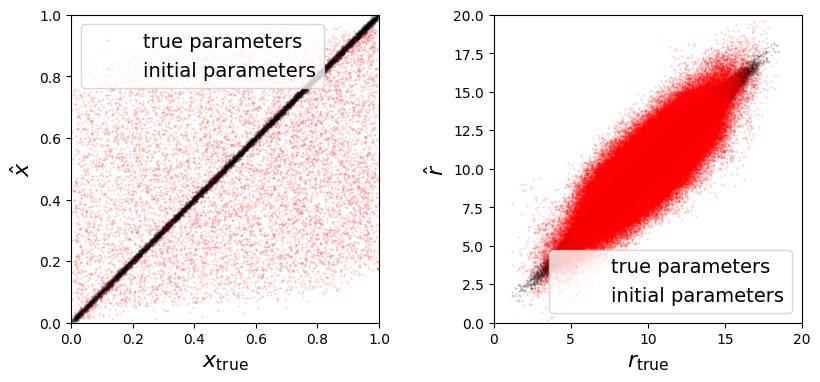

In [19]:
# Plot comparison of latent states decoded by the PF using initial value of parameters vs. ground truth

T_st = 5 # discard the first T_st samples from each batch for comparisons

alpha = 0.2

fig, axs = plt.subplots(1,2,figsize=(10,4))
axs[0].plot(x[B:,:,T_st:].flatten(), x_tp_[...,T_st:].flatten(),'k.',markersize=1,alpha=alpha)
P_temp = torch.tensor(PermMat_init.T,device=device,dtype=dtype,requires_grad=False)
axs[0].plot(x[B:,:,T_st:].flatten(), torch.matmul(P_temp, x_init_[...,T_st:]).data.numpy().flatten(),'r.',markersize=1,alpha=alpha)
axs[0].set_xlabel(r'$x_{\mathrm{true}}$',fontsize=16)
axs[0].set_ylabel(r'$\hat{x}$',fontsize=16)
axs[0].legend(['true parameters', 'initial parameters'],fontsize=14)
axs[0].axis('square')
axs[0].axis([0,1,0,1])

rmax = np.round(r_brain.max().item())
rmin = np.round(r_brain.min().item())
axs[1].plot(r_brain_[B:,:,T_st:].data.numpy().flatten(),r_tp_[...,T_st:].data.numpy().flatten(),'k.',markersize=1,alpha=alpha)
axs[1].plot(r_brain_[B:,:,T_st:].data.numpy().flatten(),r_init_[...,T_st:].data.numpy().flatten(),'r.',markersize=1,alpha=alpha)
axs[1].set_xlabel(r'$r_{\mathrm{true}}$',fontsize=16)
axs[1].set_ylabel(r'$\hat{r}$',fontsize=16)
axs[1].legend(['true parameters', 'initial parameters'],fontsize=14)
axs[1].axis('square')
axs[1].axis([rmin,rmax,rmin,rmax])

plt.show()

## 4. Run particle EM

In [21]:
lrate = 2e-3
NIterations = 25000

if model_type:
    opt_params = [G_hat_, J_hat_vec_, U_hat_, V_hat_, b_hat_]
else:
    opt_params = [G_hat_, J_hat_vec_, U_hat_, V_hat_]

optimizer = torch.optim.Adam(opt_params, lr=lrate, betas=(0.9, 0.999))

batch_size = 4

LLVec = []  # record the log likelihoods

t_st = time.time()

for iteration in range(NIterations):
    
    if iteration == NIterations//2:
        optimizer  = torch.optim.Adam(opt_params,lr=lrate/2, betas=(0.9, 0.999))

    if iteration == 3*NIterations//4:
        optimizer  = torch.optim.Adam(opt_params,lr=lrate/4, betas=(0.9, 0.999))
        
    #zero-gradients at the start of each epoch
    optimizer.zero_grad() 
    
    # select indices of batches
    idx = np.random.randint(low=0,high=B,size=batch_size)
    
    # run particle filter to get posterior for E-step
    with torch.no_grad():
        LL_b_, x_b_, P_b_, W_b_ = particlefilter(G_hat_, JVecToMat_torch(J_hat_vec_,Ns), U_hat_, V_hat_, lam.item(), r_brain_[idx]-b_hat_, y_[idx], P_process_, P_obs_, Np)

        
    # E-step to compute Q(theta,theta_n)
    C_ = Qfunction(G_hat_, JVecToMat_torch(J_hat_vec_,Ns), U_hat_, V_hat_, lam.item(), r_brain_[idx,:,T_st:]-b_hat_, y_[idx,:,T_st:], P_b_[...,T_st:], W_b_, P_process_, P_obs_)
    
    # M-step
    C_.backward() 
    G_hat_.grad[0], G_hat_.grad[9]  = 0, 0 # set gradient of G0 and G9 to zero
    optimizer.step()
    1
    # Compute and record log likelihood on the test data
    if (iteration+1)%100 == 0:
        with torch.no_grad():
            LL_rec_ = particlefilter(G_hat_, JVecToMat_torch(J_hat_vec_,Ns), U_hat_, V_hat_, lam.item(), r_brain_[B:B+10]-b_hat_, y_[B:B+10], P_process_, P_obs_, Np)[0]
            LLVec.append(LL_rec_.mean())
    
    if (iteration+1)%1000 == 0:
        # print(f"[{iteration+1}] time elapsed = {(time.time() - t_st)/60:.1f} mins , log likelihood = {LL_rec_.mean():.1f} ")
        print('[%d] time elapsed = %.1f, log likelihood: %.1f' %(iteration + 1, (time.time() - t_st)/60, LL_rec_.mean()))
        
print("Finished training.")

[1000] time elapsed = 8.8, log likelihood: -3738.8
[2000] time elapsed = 17.2, log likelihood: -3557.0
[3000] time elapsed = 24.5, log likelihood: -3515.4
[4000] time elapsed = 29.7, log likelihood: -3497.4
[5000] time elapsed = 34.8, log likelihood: -3506.0
[6000] time elapsed = 39.9, log likelihood: -3492.3
[7000] time elapsed = 45.2, log likelihood: -3490.0
[8000] time elapsed = 52.0, log likelihood: -3487.7
[9000] time elapsed = 59.5, log likelihood: -3483.9
[10000] time elapsed = 66.5, log likelihood: -3487.3
[11000] time elapsed = 73.8, log likelihood: -3481.1


KeyboardInterrupt: 

In [16]:
# Run the PF on the test data

J_hat_ = JVecToMat_torch(J_hat_vec_,Ns)
with torch.no_grad():
    LL_hat_, x_hat_, _, _ = particlefilter(G_hat_, J_hat_, U_hat_, V_hat_, lam.item(), r_brain_[B:]-b_hat_, y_[B:], P_process_, P_obs_, Np)

# print(f"log likelihood with inferred parameters = {LL_hat_.mean().data.numpy():.1f}")
print('log likelihood with inferred parameters = %.1f' %(LL_hat_.mean().data.numpy()))

# fit to neural activity
r_hat_ = torch.matmul(U_hat_, x_hat_) + b_hat_

log likelihood with inferred parameters = -3502.7


## 5. Save required variables

In [17]:
G_hat = G_hat_.detach().cpu().data.numpy()
J_hat = J_hat_.detach().cpu().data.numpy()
U_hat = U_hat_.detach().cpu().data.numpy()
V_hat = V_hat_.detach().cpu().data.numpy()
b_hat = b_hat_.detach().cpu().data.numpy()

# Estimate PermMat again
PermMat  = EstimatePermutation_ICA(U, U_hat)
PermMat_ = torch.tensor(PermMat,device=device,dtype=dtype,requires_grad=False)
PermMat_init_ = torch.tensor(PermMat_init,device=device,dtype=dtype,requires_grad=False)


# Permute the order of all the inferred variables to match ground truth order and convert to numpy arrays
x_init = torch.matmul(PermMat_init_.t(), x_init_).data.numpy()
x_hat  = torch.matmul(PermMat_.t(), x_hat_).data.numpy() 

r_init = r_init_.data.numpy()
r_hat  = r_hat_.data.numpy()

J_hat  = permuteJ(J_hat, PermMat)
J_init = permuteJ(J_init, PermMat_init)

U_hat  = np.dot(U_hat, PermMat)
U_init = np.dot(U_init, PermMat_init)

V_hat  = np.dot(PermMat.T, V_hat)
V_init = np.dot(PermMat_init.T, V_init)

In [18]:
params['Q_obs'] = Q_obs

# initial values of parameters
init_parameters = {'G_init':G_init, 'J_init':J_init, 'U_init':U_init, 'V_init':V_init, 'b_init':b_init}

# inferred parameters
inferred_parameters = {'G_hat':G_hat, 'J_hat':J_hat, 'U_hat':U_hat, 'V_hat':V_hat, 'b_hat':b_hat }

fname = 'inference_' + brain_name  + '_snr_' + str(int(np.round(SNR))) + '.pkl'
print(fname)

with open(fname, 'wb') as f:  
    pickle.dump([theta, params, init_parameters, inferred_parameters], f)
f.close()

inference_Ns_10_Nr_500_noiseseed_2022_snr_5.pkl


## 6. Visualizing results

In [19]:
def reshapeG(GVec):
    GVec = GVec.tolist()
    GVec.pop(9)
    GVec.pop(0)
    return np.array(GVec)

def offdiagonal(J):
    J_temp = J.copy()
    M = J.shape[0]
    for i in range(M):
        J_temp[i,i] = np.nan
    return J_temp

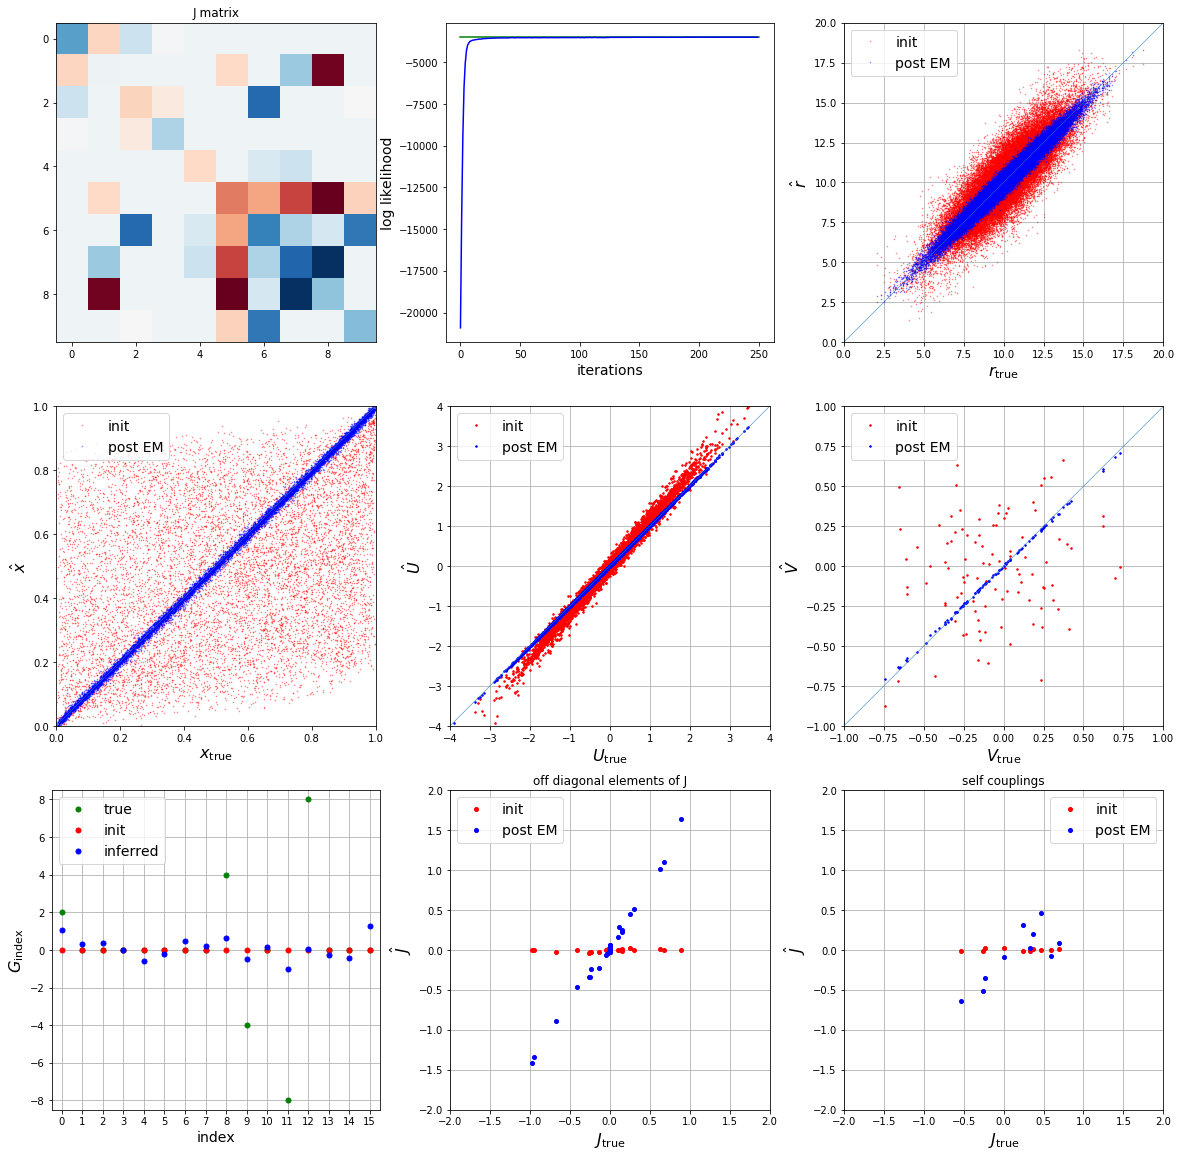

In [26]:
alpha = 0.5

fig, axs = subplots(3,3,figsize=(20,20))

axs[0,0].imshow(J,cmap='RdBu')
axs[0,0].set_title('J matrix')

axs[0,1].plot([0,len(LLVec)],LL_tp_.mean().item()*np.ones([2]),'g-')
axs[0,1].plot(LLVec,'b')
axs[0,1].set_xlabel('iterations',fontsize=14)
axs[0,1].set_ylabel('log likelihood', fontsize=14)
#axs[0,1].axis([0,200,-6000,-3000])

axs[0,2].plot(r_brain[B:B+10,:,T_st:].flatten(),r_init[0:10,:,T_st:].flatten(),'r.',markersize=1,alpha=alpha)
axs[0,2].plot(r_brain[B:B+10,:,T_st:].flatten(),r_hat[0:10,:,T_st:].flatten(),'b.',markersize=1,alpha=alpha)
axs[0,2].plot([rmin,rmax],[rmin,rmax],linewidth=0.5)
axs[0,2].set_xlabel(r'$r_{\mathrm{true}}$',fontsize=16)
axs[0,2].set_ylabel(r'$\hat{r}$',fontsize=16)
axs[0,2].legend(['init', 'post EM'], fontsize=14)
axs[0,2].axis('square')
axs[0,2].axis([rmin,rmax,rmin,rmax])
axs[0,2].grid(True)

axs[1,0].plot(x[B:,:,T_st:].flatten(), x_init[...,T_st:].flatten(),'r.', ms=1, alpha=alpha)
axs[1,0].plot(x[B:,:,T_st:].flatten(), x_hat[...,T_st:].flatten(),'b.', ms=1, alpha=alpha)
axs[1,0].plot([0,1],[0,1], linewidth=0.5)
axs[1,0].set_xlabel(r'$x_{\mathrm{true}}$', fontsize=16)
axs[1,0].set_ylabel(r'$\hat{x}$', fontsize=16)
axs[1,0].legend(['init', 'post EM'], fontsize=14)
axs[1,0].axis('square')
axs[1,0].axis([0,1,0,1])

axs[1,1].plot(U.flatten(),U_init.flatten(),'r.',markersize=3)
axs[1,1].plot(U.flatten(),U_hat.flatten(),'b.',markersize=3)
axs[1,1].axis('square')
axs[1,1].plot([-4,4],[-4,4],linewidth=0.5)
axs[1,1].axis([-4,4,-4,4])
axs[1,1].set_xlabel(r'$U_{\mathrm{true}}$',fontsize=16)
axs[1,1].set_ylabel(r'$\hat{U}$',fontsize=16)
axs[1,1].legend(['init', 'post EM'],fontsize=14)
axs[1,1].grid(True)

axs[1,2].plot(V.flatten(),V_init.flatten(),'r.',markersize=3)
axs[1,2].plot(V.flatten(),V_hat.flatten(),'b.',markersize=3)
axs[1,2].axis('square')
axs[1,2].plot([-1,1],[-1,1],linewidth=0.5)
axs[1,2].axis([-1,1,-1,1])
axs[1,2].set_xlabel(r'$V_{\mathrm{true}}$',fontsize=16)
axs[1,2].set_ylabel(r'$\hat{V}$',fontsize=16)
axs[1,2].legend(['init', 'post EM'],fontsize=14)
axs[1,2].grid(True)

axs[2,0].plot(reshapeG(G),'.',color='green', ms=10)
axs[2,0].plot(reshapeG(G_init),'r.', ms=10)
axs[2,0].plot(reshapeG(G_hat),'b.', ms=10)
axs[2,0].grid(True)
axs[2,0].set_xlabel('index',fontsize=14)
axs[2,0].set_ylabel(r'$G_{\mathrm{index}}$',fontsize=16)
axs[2,0].legend(['true','init','inferred'],fontsize=14)
axs[2,0].axis([-0.5,15.5,-8.5,8.5])
axs[2,0].set_xticks(np.arange(16))

axs[2,1].plot(JMatToVec(offdiagonal(J)),JMatToVec(offdiagonal(J_init)),'r.',markersize=8)
axs[2,1].plot(JMatToVec(offdiagonal(J)),JMatToVec(offdiagonal(J_hat)),'b.',markersize=8)
axs[2,1].axis('square')
axs[2,1].set_xlabel(r'$J_{\mathrm{true}}$',fontsize=16)
axs[2,1].set_ylabel(r'$\hat{J}$',fontsize=16)
axs[2,1].legend(['init', 'post EM'],fontsize=14)
axs[2,1].grid(True)
# axs[2,1].axis([-1.5,1.5,-1.5,1.5])
axs[2,1].axis([-2,2,-2,2])
axs[2,1].set_title('off diagonal elements of J')

axs[2,2].plot(np.diag(J), np.diag(J_init), 'r.', markersize=8)
axs[2,2].plot(np.diag(J), np.diag(J_hat), 'b.',markersize=8)
axs[2,2].axis('square')
axs[2,2].set_xlabel(r'$J_{\mathrm{true}}$',fontsize=16)
axs[2,2].set_ylabel(r'$\hat{J}$',fontsize=16)
axs[2,2].legend(['init', 'post EM'],fontsize=14)
axs[2,2].grid(True)
# axs[2,2].axis([-1.5,1.5,-1.5,1.5])
axs[2,2].axis([-2,2,-2,2])
axs[2,2].set_title('self couplings')

show()

## 7. Validate on new test data

In [27]:
B_val = 100
T_clip = 10
y_val = generate_Input(params, B_val, T+T_clip, T_low, T_high, yG_low, yG_high)

x0 = np.random.rand(Ns,B_val) # initial values

# Run TAP dynamics using true theta
x_val 	= runTAP(x0, y_val, Q_process, Q_obs, theta, params['nltype'])

# Run TAP dynamics using inferred theta
theta_hat = np.concatenate([np.array([lam]), G_hat, JMatToVec(J_hat), U_hat.flatten('F'), V_hat.flatten('F') ])
x_hat_val = runTAP(x0, y_val, Q_process, Q_obs, theta_hat, params['nltype'])

x_val = x_val[...,T_clip:].transpose(1,2,0)
x_hat_val = x_hat_val[...,T_clip:].transpose(1,2,0)
truth = x_val.flatten()
test = x_hat_val.flatten()

RMSE = 0.011


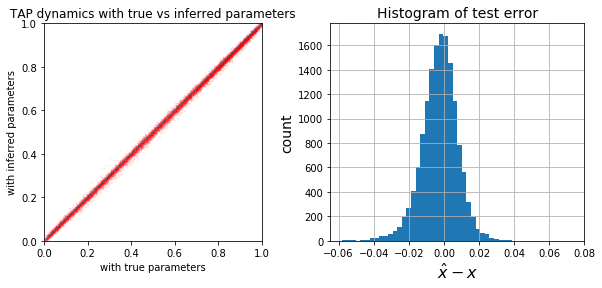

In [28]:
# print(f"RMSE = {np.sqrt(np.mean((truth - test)**2)):.3f}")
print('RMSE = %.3f' %(np.sqrt(np.mean((truth - test)**2))))

fig, axs = plt.subplots(1,2,figsize=(10,4))

axs[0].plot(truth,test,'r.',markersize=1,alpha=0.1)
axs[0].plot([0,1],[0,1],linewidth=0.5)
axs[0].set(xlabel='with true parameters', ylabel='with inferred parameters', title='TAP dynamics with true vs inferred parameters')
axs[0].axis('square')
axs[0].axis([0,1,0,1])

axs[1].hist(test-truth,50)
axs[1].set_xlabel(r'$\hat{x} - x$',fontsize=16)
axs[1].set_ylabel('count', fontsize=14)
axs[1].set_title('Histogram of test error', fontsize=14)
axs[1].grid(True)
plt.show()